# LoRA 튜닝

이 노트북에서는 PEFT 라이브러리를 사용하여 사전 학습된 모델에 LoRA 튜닝을 적용하는 방법을 소개합니다.

## LoRA 튜닝 간단 소개

LoRA(Low-Rank Adaptation)는 재매개변수화 기법입니다. 큰 가중치 행렬을 두 개의 작은 행렬로 분해하여 학습 시 이 작은 행렬만 업데이트합니다. 이 과정을 통해 전체 파라미터 수를 줄이면서도 성능을 유지하거나 향상시킬 수 있습니다.

기존 가중치는 고정(freeze)하고, 새롭게 추가된 저랭크 행렬만 학습되므로 메모리 효율적이며 학습 속도도 빠릅니다.


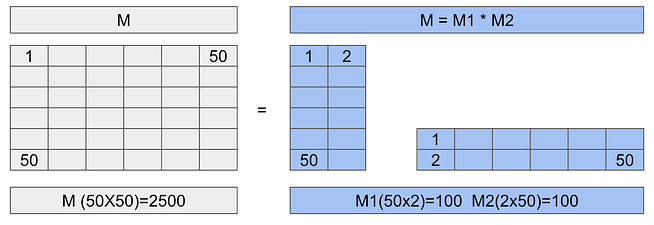

## LoRA의 작동 방식

예를 들어, 50x50 크기의 원래 가중치 행렬은 총 2,500개의 파라미터를 가지고 있습니다. 하지만 LoRA에서는 이 행렬을 두 개의 작은 행렬 — (2x50)과 (50x2) — 로 분해하여 근사합니다. 이 두 행렬은 각각 100개의 파라미터만 가지므로, 총 200개의 파라미터만 학습하면 됩니다. 이는 약 92%의 파라미터 수 절감을 의미하며, 원래 행렬이 클수록 절감 비율은 더 커집니다.

GPT-3와 같은 대형 언어 모델에서는 전체 파라미터의 약 0.02%만 학습하면 되는 경우도 있습니다. 놀라운 점은 이렇게 극단적으로 적은 수의 파라미터만 학습해도 전체 모델을 전부 파인튜닝한 것과 유사한 성능을 얻을 수 있다는 것입니다. 경우에 따라서는 성능이 더 나은 경우도 있습니다.


## PEFT 및 Datasets 라이브러리 불러오기

PEFT 라이브러리는 Hugging Face에서 제공하는 다양한 파인튜닝 기법(Lora 등)을 포함하고 있습니다.

Datasets 라이브러리는 다양한 공개 데이터셋에 손쉽게 접근할 수 있도록 도와줍니다.


In [28]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "/usr/bin/pip", line 11, in <module>
    load_entry_point('pip==20.0.2', 'console_scripts', 'pip')()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 490, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2854, in load_entry_point
    return ep.load()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2445, in load
    return self.resolve()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2451, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_ma

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "/usr/bin/pip", line 11, in <module>
    load_entry_point('pip==20.0.2', 'console_scripts', 'pip')()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 490, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2854, in load_entry_point
    return ep.load()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2445, in load
    return self.resolve()
  File "/usr/lib/python3/dist-packages/pkg_resources/__init__.py", line 2451, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_ma

## 모델 및 토크나이저 불러오기

`transformers` 라이브러리에서 모델과 토크나이저를 불러오는 데 필요한 클래스들을 가져옵니다.

이 예제에서는 Bloom 모델을 사용합니다. Bloom은 PEFT 라이브러리에서 Prompt Tuning을 적용할 수 있는 작은 크기의 효율적인 모델 중 하나입니다. 학습 시간과 Colab 환경의 메모리 한계를 고려하여 가장 작은 모델을 사용합니다.

Bloom 계열의 다양한 모델을 사용해보고 성능 차이를 비교해보는 것도 좋은 방법입니다.


In [50]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

## 사전학습된 모델로 추론하기

먼저 파인튜닝 없이 사전학습된(pre-trained) 모델을 사용해 간단한 추론을 수행합니다.  
이후 파인튜닝을 진행한 후 결과가 어떻게 달라지는지 비교할 수 있습니다.


In [51]:
# 이 함수는 입력과 모델을 받아 모델의 출력을 반환합니다.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,       # 생성할 최대 토큰 수
        repetition_penalty=1.5,              # 반복되는 문장 생성을 방지
        early_stopping=True,                 # 최대 길이에 도달하지 않아도 종료 가능
        eos_token_id=tokenizer.eos_token_id  # 종료 토큰 ID 지정
    )
    return outputs


## 파인튜닝에 사용되는 데이터셋

이번 파인튜닝에 사용되는 데이터셋은 대형 언어 모델(LLM)에 입력할 프롬프트들을 포함하고 있습니다.

사전학습된 모델을 대상으로 "동기부여 코치"처럼 행동하도록 요청해보겠습니다.


In [52]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=200)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

["I want you to act as a motivational coach.  Don't be afraid of being challenged."]


## 출력 결과 확인

모델의 출력이 정확한지는 확실하지 않지만, 적어도 우리가 기대한 "프롬프트 형태"는 아닙니다.  
따라서, 모델이 프롬프트 엔지니어처럼 동작하도록 하려면 파인튜닝이 필요합니다.


## 데이터셋 준비

사용할 데이터셋은 다음과 같습니다:  
[awesome-chatgpt-prompts](https://huggingface.co/datasets/fka/awesome-chatgpt-prompts)

이 데이터셋은 ChatGPT에 입력할 수 있는 다양한 프롬프트들을 포함하고 있어, 모델을 프롬프트 엔지니어처럼 학습시키기에 적합합니다.


In [53]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

# 프롬프트 생성에 사용할 데이터셋 불러오기
data = load_dataset(dataset)

# 데이터셋의 "prompt" 컬럼에 토크나이저 적용 (배치 처리)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)

# 학습 샘플로 데이터셋의 처음 50개 선택
train_sample = data["train"].select(range(50))

# 불필요한 'act' 컬럼 제거
train_sample = train_sample.remove_columns('act')

# 데이터셋 확인
display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [54]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

## 데이터셋 설명 및 출력 형태

- 이 데이터셋은 ChatGPT와 같은 대형 언어 모델에 입력할 다양한 **프롬프트(prompt)** 들을 포함하고 있습니다.
- 각 데이터 샘플은 사용자가 모델에 제공할 텍스트 프롬프트와, 이를 토크나이즈(tokenize)한 결과를 함께 가지고 있습니다.

### 출력 형태 예시
- `prompt`: 원본 텍스트 프롬프트 (문장 형태)
- `input_ids`: 프롬프트를 토크나이저가 숫자 토큰 ID로 변환한 리스트
- `attention_mask`: 입력 시퀀스에서 실제 토큰과 패딩 토큰을 구분하기 위한 마스크 (1은 실제 토큰, 0은 패딩)


## 파인튜닝 시작

먼저 LoRA 설정(config)을 생성하는 것이 필요합니다.


In [55]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(
    r=4,                     # R 값이 클수록 학습할 파라미터가 많아짐
    lora_alpha=1,            # 가중치 행렬의 크기를 조절하는 스케일링 팩터, 보통 1로 설정
    target_modules=["query_key_value"],  # LoRA를 적용할 모듈 목록 (위 URL에서 확인 가능)
    lora_dropout=0.05,       # 과적합 방지를 위한 드롭아웃 비율
    bias="lora_only",        # bias 파라미터를 학습할지 여부 지정
    task_type="CAUSAL_LM"    # 작업 유형: 인과적 언어 모델링
)


## LoRA 주요 파라미터 설명

- **r**  
  학습할 파라미터 수를 결정하는 가장 중요한 값입니다.  
  값이 클수록 더 많은 파라미터가 학습되며, 이는 모델이 입력과 출력 간의 더 복잡한 관계를 학습할 수 있음을 의미합니다.

- **target_modules**  
  LoRA를 적용할 모델 내 모듈 목록입니다.  
  [Hugging Face 문서](https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)에서 확인할 수 있습니다.

- **lora_dropout**  
  일반적인 드롭아웃과 동일하게 과적합을 방지하기 위해 사용됩니다.

- **bias**  
  보통 텍스트 분류(task)에서는 `"none"`을, 챗봇이나 질문답변과 같은 작업에는 `"all"` 또는 `"lora_only"`를 사용합니다.  
  저는 `"lora_only"`를 선택했습니다.

- **task_type**  
  모델이 학습될 작업 유형을 지정합니다. 이번 예제에서는 텍스트 생성(`"CAUSAL_LM"`)입니다.

---

| Task Type                      | 설명                                                                  |
| ------------------------------ | ------------------------------------------------------------------- |
| `TaskType.CAUSAL_LM`           | GPT와 같은 **Auto-regressive Language Modeling** (예: 텍스트 생성)           |
| `TaskType.SEQ_2_SEQ_LM`        | T5, BART와 같은 **Sequence-to-Sequence Language Modeling** (예: 번역, 요약) |
| `TaskType.TOKEN_CLS`           | **Token Classification** (예: 개체명 인식 NER)                            |
| `TaskType.SEQ_CLS`             | **Sequence Classification** (예: 감성 분석, 문장 분류)                       |
| `TaskType.MULTI_LABEL_CLS`     | **Multi-label Classification** (하나의 입력에 대해 여러 개의 라벨 분류)             |
| `TaskType.QUESTION_ANSWERING`  | **질문-응답 시스템** (예: SQuAD 스타일)                                        |
| `TaskType.FILL_MASK`           | **Masked Language Modeling** (예: BERT 스타일 마스크 채우기)                  |
| `TaskType.CAUSAL_LM_STREAMING` | **Streaming 텍스트 생성** (스트리밍 환경에서 Causal LM)                          |
| `TaskType.SPAN_ANNOTATION`     | **스팬 기반 주석** (예: BIO 태깅 등 NER 변형)                                   |

---

## PEFT 모델 생성하기


In [56]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 466,944 || all params: 559,607,808 || trainable%: 0.0834
None


학습 가능한 파라미터 수는 사전학습된 모델의 전체 파라미터 수에 비해 매우 적습니다.


In [57]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

`TrainingArguments`에서는 학습할 에포크 수, 출력 디렉터리, 학습률(learning rate) 등을 설정합니다.

In [59]:
# TrainingArguments 생성하기
import transformers
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=output_directory,      # 모델과 체크포인트를 저장할 경로
    auto_find_batch_size=True,        # 데이터 크기에 맞는 적절한 배치 크기 자동 탐색
    learning_rate=3e-2,               # 전체 파인튜닝보다 높은 학습률 설정
    num_train_epochs=3,               # 학습할 에포크 수
    use_cpu=False                      # CPU 사용 설정 (GPU가 없을 경우)
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 모델 학습 준비

모델을 학습하려면 다음이 필요합니다:

- PEFT 모델
- `training_args` (학습 설정)
- 학습에 사용할 데이터셋
- `DataCollator`의 결과물 (데이터셋을 블록 단위로 처리할 수 있도록 준비된 형태)


In [60]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

/home/a202520153/.local/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


TrainOutput(global_step=6, training_loss=3.03417174021403, metrics={'train_runtime': 7.87, 'train_samples_per_second': 19.06, 'train_steps_per_second': 0.762, 'total_flos': 39575872389120.0, 'train_loss': 3.03417174021403, 'epoch': 3.0})

In [61]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [62]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

## 파인튜닝된 모델로 추론하기

In [65]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델과 입력 모두 동일한 디바이스로 이동
loaded_model.to(device)
input_sentences = tokenizer("I want you to act as a motivational coach.", return_tensors="pt").to(device)
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=300)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach. I will help motivate people by helping them develop their confidence and motivation levels, enabling the person who is struggling with depression or anxiety issues in order for him/her not only feel better but also improve his/ her life quality of living.  My first request is: "I need some advice on how can we overcome our current struggles"  "I\'ve been feeling suicidal lately so it makes me very sad that my thoughts are always going away when I\'m thinking about suicide attempts at any time"" "My family has become too dependent upon alcoholic individuals because they have no other choice than drinking more amounts every day which leads us into mental health problems such as: bipolar disorder etc., eating disorders like ADHD and/or PTSD (traumatic stress), insomnia related conditions including sleep apnea/hypnysma/full body dysmetria/cognitive behavioural difficulties)."I don\'t know if this word could be used correctly according your conte

## 결과 비교


- **사전학습 모델:**  
  *I want you to act as a motivational coach.* Don't be afraid of being challenged.

- **파인튜닝 모델:**  
  I want you to act as a motivational coach. I will provide some information about someone's motivation and goals, but it should be your job in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have...

보시다시피, 파인튜닝한 모델의 결과는 학습에 사용된 데이터셋 샘플과 매우 유사합니다.  
그리고 우리는 단 10 에포크, 아주 적은 데이터만으로 학습을 진행했습니다.

---

## 계속 학습해보기

노트북 내 모든 변수들을 자유롭게 바꾸며 다양한 실험을 해보시고, 자신만의 결론을 도출해보세요.

특히 **lora_config** 값들을 조절해보면 더 적은 에포크 수로도 더 좋은 결과를 얻어  
시간과 비용을 절약할 수 있을지도 모릅니다. :-)
